<a href="https://colab.research.google.com/github/mne70let/visualize-us-stocks-data/blob/develop/visualize_us_stocks_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Gdrive

In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Import libs & set global vars

In [57]:
!pip install yfinance
import yfinance as yf
import datetime
from datetime import datetime
from datetime import date
import urllib.request, urllib.parse, urllib.error
import ssl
import re
import json
import csv
import time
from google.colab import drive
import shutil
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab as plb
from matplotlib.ticker import StrMethodFormatter

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

print('Libraries uploaded')

Libraries uploaded


#Specify Gdrive Folder and APIs

In [58]:
#folder on Google Drive:
gdfolder='/content/gdrive/MyDrive/Coding/StockData/'
#yrs of history to download fundamentals
yrs=20
pricedatemin='2000-01-01'
pricedatemax='2021-01-01'
#set apikey once:

source={'site' : 'https://financialmodelingprep.com/api/v3/', 'apikey' : 'f02628de5ce2be84c9b758c979ded870'}
## https://financialmodelingprep.com/developer/docs/dashboard
#source={'site' : 'https://fmpcloud.io/api/v3/', 'apikey' : '678054f957cd7cd14c361b5610e2d24e'}
## https://fmpcloud.io/dashboard

#Stock class definition

In [59]:
#--------------------------
#Stock class definition
#--------------------------
class stock_class:
  'This is a class to work download stocks'
  #Key class attributes
  fundamentals = pd.DataFrame() #fundamentals dynamics
  hist_price_div = pd.DataFrame() #price and divs dynamics
  profile = pd.DataFrame() #company profile
  n_api=0 #num of api requests

  #Parameters required at class creation
  def __init__(self, ticker, benchmark = False):
    self.ticker=ticker
    self.benchmark=benchmark
    #getting fundamentals and prices as class attributes using functions (methods) defined below:
    self.hist_price_div = self.read_from_gd()[0]  
    self.fundamentals = self.read_from_gd()[1]
    self.profile = self.read_from_gd()[2]

    #If no profile of gdrive - get it from yahoo finance
    if (self.profile.empty == True) and (self.benchmark == False):
      self.profile=pd.DataFrame(self.read_company_info_from_yahoo())
      self.profile.to_csv(self.ticker+ '_profile.csv')
      shutil.copy(self.ticker+ '_profile.csv', gdfolder + self.ticker+ '_profile.csv')

    #If no price&divs data on gdrive - do request to API
    if (self.hist_price_div.empty == True):
        yf_ticker = yf.Ticker(self.ticker)
        self.hist_price_div=yf_ticker.history(start = pricedatemin, end = pricedatemax)
        self.hist_price_div
        self.hist_price_div.drop(self.hist_price_div.columns.difference(['Close', 'Dividends']), 1, inplace=True )  #drop all except
        self.hist_price_div.rename(columns={'Close':'close',
                                      'Dividends':'adjDividend'}, 
                              inplace=True)
        self.hist_price_div.to_csv(self.ticker+ '_hist_price_div.csv')
        shutil.copy(self.ticker+ '_hist_price_div.csv', gdfolder + self.ticker+ '_hist_price_div.csv')
        
        ##Working with profile and fundamentals dynamics (not for benchmarks):
        if self.benchmark == False:
          ratios=self.read_from_api(self.ratios_url())
          ratios_ttm=self.read_from_api(self.ratios_ttm_url())
          key_metrics=self.read_from_api(self.key_metrics_url())
          key_metrics_ttm=self.read_from_api(self.key_metrics_ttm_url())      
          self.fundamentals = pd.concat([ratios, key_metrics], axis =1)
          self.fundamentals = self.fundamentals.loc[:,~self.fundamentals.columns.duplicated()] #removes duplicated columns
          #Combining TTM (as a first row) with other annual fundamentals     
          fundamentals_ttm = pd.concat([ratios_ttm, key_metrics_ttm], axis =1)
          fundamentals_ttm.insert(0, "date", [pricedatemax], False) 
          fundamentals_ttm.insert(0, "symbol", self.ticker , False)
          fundamentals_ttm['date'] = pd.to_datetime(fundamentals_ttm['date'])
          fundamentals_ttm.set_index('date', inplace=True)
          for column in fundamentals_ttm.columns:
            fundamentals_ttm.rename({column:column.replace('TTM','')}, axis='columns',inplace=True)
          fundamentals_ttm = fundamentals_ttm.loc[:,~fundamentals_ttm.columns.duplicated()] #removes duplicated columns
          self.fundamentals = pd.concat([self.fundamentals, fundamentals_ttm], axis =0, join='inner')
          self.fundamentals.sort_index(inplace=True)
          self.fundamentals.index=pd.to_datetime(self.fundamentals.index) #conversion to timestamp
        self.fundamentals.to_csv(self.ticker+ '_fundamentals.csv')
        shutil.copy(self.ticker+ '_fundamentals.csv', gdfolder + self.ticker+ '_fundamentals.csv')      
        self.n_api=self.n_api+6

  #Defining urls
  def hist_price_url (self):          
    return source['site'] + "historical-price-full/"+self.ticker+"?from=" + pricedatemin + "&to=" + pricedatemax + "&apikey="+source['apikey']
  def hist_divs_url (self):
    return source['site'] + "historical-price-full/stock_dividend/"+self.ticker+"?from=" + pricedatemin + "&to=" + pricedatemax + "&apikey="+source['apikey']
 
  def ratios_url (self):
    return source['site'] + "ratios/"+self.ticker+"?limit=" + str(yrs) + "&apikey="+source['apikey']
  def ratios_ttm_url (self):
    return source['site'] + "ratios-ttm/"+self.ticker+"?&apikey="+source['apikey']
  def key_metrics_url (self):
    return source['site'] + "key-metrics/"+self.ticker+"?limit=" + str(yrs) + "&apikey="+source['apikey']
  def key_metrics_ttm_url (self):
    return source['site'] + "key-metrics-ttm/"+self.ticker+"?&apikey="+source['apikey']
  def growth_url (self):
    return source['site'] + "financial-growth/"+self.ticker+"?limit=" + str(yrs) + "&apikey="+source['apikey']
  def company_profile_url (self):
    return "https://finance.yahoo.com/quote/"+self.ticker+"/profile?p="+self.ticker
  def company_holders_url (self):
    return "https://finance.yahoo.com/quote/"+self.ticker+"/holders?p="+self.ticker
  def company_summary_url (self):
    return "https://finance.yahoo.com/quote/"+self.ticker+"?p="+self.ticker

  #Function to read data from API to dataframe
  def read_from_api(self, url):
    try:
      data = urllib.request.urlopen(url, context=ctx).read()
      info = json.loads(data)
      if "historical" in url:
        info = pd.DataFrame(info['historical'])
      else:
        info = pd.DataFrame(info)      
      if 'date' in info: 
        info['date'] = pd.to_datetime(info['date'])
        info.set_index('date', inplace=True)
      return info 
    except:
      info = pd.DataFrame()
      return info

  #Function to get company info
  def read_company_info_from_yahoo (self):
    try:
      html = urllib.request.urlopen(self.company_profile_url(), context=ctx).read()
      soup = BeautifulSoup(html, 'html.parser')
      tags = soup('span',{'class': 'Fw(600)'})
      tagsd = soup('p',{'Mt(15px) Lh(1.6)'})
      html = urllib.request.urlopen(self.company_holders_url(), context=ctx).read()
      soup = BeautifulSoup(html, 'html.parser')
      tagh = soup('td',{'class': 'Py(10px) Va(m) Fw(600) W(15%)'})
      return [{'symbol': self.ticker, 'Sector': tags[0].text, 'Industry': tags[1].text, 'NumEmployees': tags[2].text , 'InstitutionalHolders': tagh[1].text , 'InsideHolders': tagh[0].text , 'Description' : tagsd[0].text}]
    except:
      return [{'symbol': '', 'Sector': '', 'Industry': '', 'NumEmployees': '' , 'InstitutionalHolders': '' , 'InsideHolders': '', 'Description' : ''}]

  #Function to get ttm values from yahoo
  def get_ttm_from_yahoo (self):
    try:
      tgt_website = 'https://sg.finance.yahoo.com/quote/' + self.ticker + '/key-statistics?p=' + self.ticker
      tgt_website = r"{}".format(tgt_website)
      # The web page is make up of several html table. By calling read_html function.
      # all the tables are retrieved in dataframe format.
      # Next is to append all the table and transpose it to give a nice one row data.
      df_list = pd.read_html(tgt_website)
      result_df = df_list[0]
      for df in df_list[1:]:
          result_df = result_df.append(df)
      # The data is in column format.
      # Transpose the result to make all data in single row
      result_df=result_df.set_index(0).T
      try: # to avoid errors if NaN
        result_df['Forward annual dividend yield 4'][1]=result_df['Forward annual dividend yield 4'][1].replace('%','')
      except: 
        result_df['Forward annual dividend yield 4'][1]=0      
      result_df.loc[1]=pd.to_numeric(result_df.loc[1], errors='coerce')
      #result_df['52-week high 3'][1]
      #result_df['52-week high 3'][1]
      #result_df['52-week high 3'][1]
      #result_df['Diluted EPS (ttm)'][1]
      #result_df['Forward annual dividend yield 4'][1]      
      return [ {'date': date.today(), 'PEttm': result_df['Trailing P/E'][1], 'EPS': result_df['Diluted EPS (ttm)'][1], 'DivYield': (result_df['Forward annual dividend yield 4'][1])/100, 'RevPerShare': result_df['Revenue per share (ttm)'][1]} ]
    except:
      return [ {'date': date.today(), 'PEttm': '', 'EPS': '', 'DivYield': '', 'RevPerShare': '' } ]

  #Function to read data from google drive
  def read_from_gd (self):
    #1 getting hist_price_div
    try:
      shutil.copy(gdfolder + self.ticker+ '_hist_price_div.csv', self.ticker+ '_hist_price_div.csv')
      hist_price_div = pd.read_csv(self.ticker+ '_hist_price_div.csv', index_col=0)
      hist_price_div.index=pd.to_datetime(hist_price_div.index)
    except:
      hist_price_div = pd.DataFrame()
    # 2 Getting fundamentals    
    try:
      shutil.copy(gdfolder + self.ticker+ '_fundamentals.csv', self.ticker+ '_fundamentals.csv')
      fundamentals = pd.read_csv(self.ticker+ '_fundamentals.csv', index_col=0)
      fundamentals.index=pd.to_datetime(fundamentals.index) #conversion to timestamp
    except:
      fundamentals = pd.DataFrame()
    # 3 Getting company profile    
    try:
      shutil.copy(gdfolder + self.ticker+ '_profile.csv', self.ticker+ '_profile.csv')
      profile = pd.read_csv(self.ticker+ '_profile.csv', index_col=0)
      #profile.index=pd.to_datetime(profile.index) #conversion to timestamp
    except:
      profile = pd.DataFrame()
    return [hist_price_div, fundamentals, profile] 

  def limit_dataframes (self, datemin, datemax):
    try:
      self.hist_price_div=self.hist_price_div[datemin:datemax]
      self.fundamentals=self.fundamentals[datemin:datemax]  
    except:
      pass
    
  #Function to get CAGR based on price changes only
  def cagr_price (self, datemin=pricedatemin, datemax=pricedatemax):
    try:
      tstep1=self.hist_price_div.index.get_loc(datemin, method='nearest')
      tstep2=self.hist_price_div.index.get_loc(datemax, method='nearest')
      delta=(self.hist_price_div.index[tstep2]-self.hist_price_div.index[tstep1]).days
      cagr_price=(self.hist_price_div.iloc[tstep2,0]/self.hist_price_div.iloc[tstep1,0])**(365/delta)-1
      return cagr_price
    except:
      print(self.ticker + ': error with CAGR calc')

  def growth (self, param, years):
    try:
      self.fundamentals
      g=list()
      i=len(self.fundamentals.index)-1      
      while i >= 1:
        g.append(self.fundamentals[param][i]/self.fundamentals[param][i-1]-1)
        i=i-1
      if years == 3:
        ret=sum(g[1:4])/3
      elif years ==1:
        ret=g[0]
      else:
        ret=''
      return ret
    except:
      return ''

  def average (self, param, years):
    try:
      l=len(self.fundamentals.index)
      ret = sum(self.fundamentals[param][(l-years):l]) / years
      return ret
    except:
      return ''

#Specify list of companies to analyze (by default goes from SP500

In [60]:
#Getting list of SP500 companies:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500companies = table[0]
sp500companies=sp500companies.Symbol.to_list()

companies_to_remove= ['UTX', 'DWDP', 'BRK.B', 'PCLN', 'GGP']
sp500companies=list(set(sp500companies).difference(companies_to_remove))
#removing companies from a list

#adding companies which are not in SP500
stocknames = sp500companies[0:1] 

#stocknames= ['TSLA'] #['PFE', 'PM', 'LMT', 'KR','TSN','GIS','DG','WMT','PG','ANTM','BIIB','CVS','HCA','HUM','AMGN','UNH','MRK','REGN','INTC','HPQ','IBM','CSCO','AMAT','LRCX','VMC','APD','DHI','BBY','LOW','ORLY','HD','PCAR','EMR','EQR','MET','REGI','XOM','OMC','VZ?','CMCSA','EA','ATVI']
#stocknames=list(set(stocknames))
#stocknames= ['ABBV', 'BABA', 'BIIB', 'CCL', 'CIEN', 'CSCO', 'DHI', 'HUM', 'IBM', 'INTC', 'JPM', 'MRK', 'MSFT', 'PM', 'RDS-A', 'REGI', 'V', 'VRTX', 'VZ', 'XOM', 'NEM', 'DG', 'LMT', 'HII', 'NEE', 'HD', 'CLX', 'PG', 'TSN']
#stocknames= ['BMY']
#stocknames=list(set(stocknames))

len(stocknames)

1

# Get stock info 

In [61]:
#Using dictionary to create dynamic variables
stocks={}
n_api_requests=0
for stockname in stocknames:
  stocks[stockname] = stock_class(stockname);
  n_api_requests = n_api_requests+stocks[stockname].n_api
  print(stockname + ' processed. Total number of API requests: ', n_api_requests)

MCD processed. Total number of API requests:  0


In [62]:
#Getting benchmarks data
benchmarknames=['SPY']
benchmarks={}
n_api_requests=0
for benchmarkname in benchmarknames:
  benchmarks[benchmarkname] = stock_class(benchmarkname, benchmark = True) ;
  n_api_requests = n_api_requests+benchmarks[benchmarkname].n_api
  print('Number of requests to API: ', n_api_requests)

Number of requests to API:  0


# Data visualization code

In [65]:
def vis_stock(stock, print_to_folder='__Stock_Analysis/', name_prefix=''):
  try:
    fontsize_common=14
    fontfamily_common='monospace'

    stocks[stock].limit_dataframes('2015-12-31',pricedatemax)
    stocks[stock].cagr_price('2015-12-31',pricedatemax)

    #Merging price and fundammental data
    for_plot=stocks[stock].hist_price_div.merge(stocks[stock].fundamentals, left_index=True, right_index=True, how='outer')
    #Interest coverage calc
    for_plot['Ones']=1
    for_plot['interestCoverage']=pd.to_numeric(for_plot['interestCoverage'], errors='coerce')
    for_plot['interest/EBIT']=for_plot['Ones'].div(for_plot['interestCoverage']).fillna(0)
    for_plot['interest/EBIT']=pd.to_numeric(for_plot['interest/EBIT'], errors='coerce')
    for_plot.loc[for_plot['interest/EBIT'] == 0,'interest/EBIT'] = np.nan

    for_plot['revenuePerShareInt']=for_plot['revenuePerShare'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['freeCashFlowPerShare']=for_plot['freeCashFlowPerShare'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['netIncomePerShare']=for_plot['netIncomePerShare'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['netProfitMargin']=for_plot['netProfitMargin'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['operatingProfitMargin']=for_plot['operatingProfitMargin'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['interest/EBIT']=for_plot['interest/EBIT'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['netDebtToEBITDA']=for_plot['netDebtToEBITDA'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['earningsYield']=for_plot['earningsYield'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['dividendYield']=for_plot['dividendYield'].interpolate(method='linear', limit_direction = 'backward')
    for_plot['returnOnEquity']=for_plot['returnOnEquity'].interpolate(method='linear', limit_direction = 'backward')

    #Condition
    for_plot['payoutRatio'] = for_plot['payoutRatio'].clip(upper=1)
    for_plot['payoutRatio']=for_plot['payoutRatio'].interpolate(method='linear', limit_direction = 'backward')

    #Plotting TTM data
    ttm=pd.DataFrame(stocks[stock].get_ttm_from_yahoo())
    ttm['date']=pd.to_datetime(ttm['date'])
    ttm['YE']=1/ttm['PEttm']
    ttm.set_index('date', inplace=True)

    fig,ax = plt.subplots(3, 2, figsize=(30,3*5))
    #--------------
    #Plot [0,0]----
    #--------------
    for_plot.plot( 
                y=['close'],
                label=['Close Price'],                                                       
                color = ['dimgrey'],
                linewidth = 3,
                alpha=0.6,
                fontsize=fontsize_common, ax=ax[0,0])
    ax[0,0].legend(fontsize=fontsize_common-2)
    ax[0,0].legend(loc = 'upper left', ncol = 1, fontsize=fontsize_common-2)
    ax001 = ax[0,0].twinx() 
    for_plot.plot(
                y=['revenuePerShareInt'],
                label=[''],                                                       
                color = ['skyblue'],
                linestyle='-',       
                linewidth = 8,
                alpha=0.5,
                fontsize=fontsize_common, ax=ax001)
    for_plot.plot(
                y=['revenuePerShare'],
                label=['Revenue per share'],                  
                color = ['cornflowerblue'],
                linestyle='-',       
                linewidth = 8,
                marker="o", markersize=12,
                alpha=0.5,
                fontsize=fontsize_common, ax=ax001)
    ttm.plot(
                y=['RevPerShare'],
                label=['Revenue TTM'],                                                       
                color = ['cornflowerblue'],
                marker="o", markersize=12,
                alpha=0.75,
                fontsize=fontsize_common, ax=ax001)   
    ax001.legend(loc = 'lower left', ncol = 1, fontsize=fontsize_common-2)

    #--------------
    #Plot [1,0]----
    #--------------
    for_plot.plot(
                y=['freeCashFlowPerShare'], 
                label=['FCF'],                                                       
                color = ['orange'],
                linestyle='-',       
                linewidth = 8,
                alpha=0.5,
                fontsize=fontsize_common, ax=ax[1,0])
    for_plot.plot(
                y=['netIncomePerShare'],
                label=['EPS'],                                                       
                color = ['green'],
                linestyle='-',       
                linewidth = 8,
                alpha=0.25,
                fontsize=fontsize_common, ax=ax[1,0])
    ttm.plot(
                y=['EPS'],
                label=['EPS TTM'],                                                       
                color = ['green'],
                marker="o", markersize=12,
                alpha=0.5,
                fontsize=fontsize_common, ax=ax[1,0])    

    ax101 = ax[1,0].twinx()
    for_plot.plot( 
                y=['close'],  
                color = ['grey'],
                legend=False,                 
                linewidth = 3,
                alpha=0.0,
                fontsize=fontsize_common, ax=ax101)
    ax[1,0].legend(loc = 'upper left', ncol = 1 ,fontsize=fontsize_common-2)
    ax101.set_ylim(ax[1,0].get_ylim()[0], ax[1,0].get_ylim()[1])

    #--------------
    #Plot [0,1]----
    #--------------
    for_plot.plot( 
                y=['adjDividend'],
                label=['Dividends'],                                                       
                color = ['forestgreen'],
                marker="^", markersize=15,
                linewidth = 0,
                alpha=0.7,
                fontsize=fontsize_common, ax=ax[0,1])
    ax[0,1].legend(fontsize=fontsize_common-2)
    ax011 = ax[0,1].twinx() 
    for_plot.plot(
                y=['payoutRatio'],
                label=['DivPayout Ratio'],                                     
                color = ['green'],
                linewidth = 8,
                alpha=0.8,
                fontsize=fontsize_common, ax=ax011)
    for_plot.plot(
                y=['close'],  
                color = ['grey'],
                label=[''],                                                       
                linewidth = 0,
                legend=False, 
                alpha=0.0,
                fontsize=fontsize_common, ax=ax011)
    try:
      ax[0,1].set_ylim(for_plot.adjDividend[for_plot.adjDividend>0].min()*.95,for_plot.adjDividend[for_plot.adjDividend>0].max()*1.05)
      ax011.set_ylim(0, round(for_plot["payoutRatio"].max(),2)+.1)
    except:
      ax[0,1].set_ylim(0,1)
      ax011.set_ylim(0,1)
    ax[0,1].legend(loc = 'upper right', ncol = 1 , fontsize=fontsize_common-2)
    ax011.legend(loc = 'lower right', ncol = 1, fontsize=fontsize_common-2)

    #--------------
    #Plot [2,1]----
    #--------------
    for_plot.plot( 
                y=['netDebtToEBITDA'],
                label=['NetDebt/EBITDA'],                    
                color = ['red'],
                linewidth = 8,
                alpha=0.5,
                fontsize=fontsize_common, ax=ax[2,1])
    ax[2,1].legend(fontsize=fontsize_common-2)
    ax211 = ax[2,1].twinx() 
    for_plot.plot(
                y=['interest/EBIT'],  
                color = ['darkorange'],
                linewidth = 8,
                alpha=0.75,
                fontsize=fontsize_common, ax=ax211)
    for_plot.plot(
                y=['close'],
                label=[''],                                                       
                color = ['grey'],
                linewidth = 0,
                alpha=0.0,
                fontsize=fontsize_common, ax=ax211)

    ax[2,1].legend(loc = 'upper right', ncol = 1 ,fontsize=fontsize_common-2,)
    ax211.legend(loc = 'lower right', ncol = 1, fontsize=fontsize_common-2)
    ax[2,1].axhline(3, linewidth = 2, linestyle='--', color='black', zorder=1, alpha=0.4)	
    ax211.set_ylim(0, max(0.5,round(for_plot['interest/EBIT'][for_plot['interest/EBIT'] > 0].max(),1)+0.1))
    ax[2,1].set_ylim(0, 5)

    #ProfitMargins
    #--------------
    #Plot [2,0]----
    #--------------
    for_plot.plot(
                y=['operatingProfitMargin','netProfitMargin'],  
                color = ['skyblue','green'],
                label=['Operating Margin','Net Margin'],  
                kind='area',
                stacked=False,
                linestyle='-',       
                linewidth = 3,
                alpha=0.2,
                fontsize=fontsize_common, ax=ax[2,0])
    
    ax201 = ax[2,0].twinx()  
    for_plot.plot(
                y=['returnOnEquity'],
                label=['ROE'],  
                color = ['violet'],
                linewidth = 5,
                linestyle='--',
                alpha=0.8,
                fontsize=fontsize_common, ax=ax201)  

    for_plot.plot( 
                y=['close'],  
                label=[''],
                color = ['grey'],
                linewidth = 3,
                alpha=0.0,
                fontsize=fontsize_common, ax=ax201)

    ax[2,0].set_ylim(ymin=0)
    ax201.set_ylim(0, round(for_plot['returnOnEquity'].max(),1)+0.1)
    ax[2,0].legend(loc = 'lower right', ncol = 1 ,fontsize=fontsize_common-2)

    #Earning and dividend yields
    #--------------
    #Plot [1,1]----
    #--------------
    for_plot.plot(
                y=['earningsYield', 'dividendYield'],
                label=['Earning Yield','Dividend Yield'],  
                color = ['purple', 'gold'],
                linestyle='-',       
                linewidth = 8,
                alpha=0.8,
                fontsize=fontsize_common, ax=ax[1,1])
    ttm.plot(
                y=['YE', 'DivYield'],
                label=['YE TTM', 'DivYield TTM'],                                                       
                color = ['purple', 'gold'],
                marker="o", markersize=12,
                alpha=1,
                fontsize=fontsize_common, ax=ax[1,1])    
    ax111 = ax[1,1].twinx()
    for_plot.plot( 
                y=['close'],  
                color = ['grey'],
                linewidth = 3,
                alpha=0.0,
                label=[''],                                                       
                fontsize=fontsize_common, ax=ax111)
    ax[1,1].set_ylim(ymin=0)
    ax111.set_ylim(ax[1,1].get_ylim()[0], ax[1,1].get_ylim()[1])
    ax[1,1].yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    ax111.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    ax[1,1].legend(loc = 'upper left', ncol = 1 ,fontsize=fontsize_common-2)
    ax[1,1].axhline(0.05, linewidth = 2, linestyle='--', color='black', zorder=1, alpha=0.4)	

    #Final styling
    for axn in ax.reshape(-1): 
      axn.tick_params(axis='x', labelcolor='black', labelrotation=0, labelbottom=True)
      axn.set_xlabel('')
      plt.setp(axn.xaxis.get_majorticklabels(), ha="center")

    #Final labeling
    ax[0,0].set_title('Share Price & Revenue per Share', fontsize=fontsize_common, family =fontfamily_common, weight='semibold')
    ax[0,0].set_ylabel('Shere price, USD', fontsize=fontsize_common, fontweight='semibold', family =fontfamily_common)
    ax001.set_ylabel('Revenue per share, USD', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)

    ax[0,1].set_title('Dividends', fontsize=fontsize_common, family =fontfamily_common, weight='semibold')
    ax[0,1].set_ylabel('Dividends, USD', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)
    ax011.set_ylabel('Dividends payout ratio', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)

    ax[2,1].set_title('Debt', fontsize=fontsize_common, family =fontfamily_common, weight='semibold')
    ax[2,1].set_ylabel('NetDebt/EBITDA', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)
    ax211.set_ylabel('Interest/EBIT', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)

    ax[1,0].set_title('Earnings and Free Cash Flow Per Share', fontsize=fontsize_common, family =fontfamily_common, weight='semibold')
    ax[1,0].set_ylabel('EPS and FCFps, USD', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)

    ax[2,0].set_title('Effectiveness', fontsize=fontsize_common, family =fontfamily_common, weight='semibold')
    ax[2,0].set_ylabel('Profit margins', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)
    ax201.set_ylabel('ROE', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)

    ax[1,1].set_title('Yearning and Dividend Yields', fontsize=fontsize_common, family =fontfamily_common, weight='semibold')
    ax[1,1].set_ylabel('Earnings & div yields', fontsize=fontsize_common, fontweight='bold', family =fontfamily_common)

    #ax001.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    #ax001.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    #Adding stock info
    plt.tight_layout()
    plt.gcf().text(0.03, 1, 'Ticker: ' + stock, fontsize=fontsize_common, style='italic', fontweight='bold')
    plt.gcf().text(0.03, 0.98,\
                   'Sector - ' + stocks[stock].profile.Sector[0] +
                   '. Industry - ' + stocks[stock].profile.Industry[0], 
                   fontsize=fontsize_common, style='italic')    
    plt.gcf().text(0.03, 0.96,\
                   'CAGR: ' + str(round(stocks[stock].cagr_price(),3)),                  
                   fontsize=fontsize_common, style='italic')    
    plt.gcf().text(0.03, 0.94, stocks[stock].profile.Description[0][0:285] + '...', fontsize=fontsize_common, style='italic')
    plt.subplots_adjust(top = 0.9, hspace=0.25, wspace = 0.15)

    if name_prefix != '': name_prefix= name_prefix + ' '

    #Export PDF to g-drive
    if print_to_folder != '':
      fig.savefig(stock + '.pdf', quality=90, bbox_inches='tight' )
      shutil.copy(stock + '.pdf' ,'/content/gdrive/My Drive/'+ print_to_folder + name_prefix + stock + '.pdf')


  except:
    pass

# Data visualization




MCD


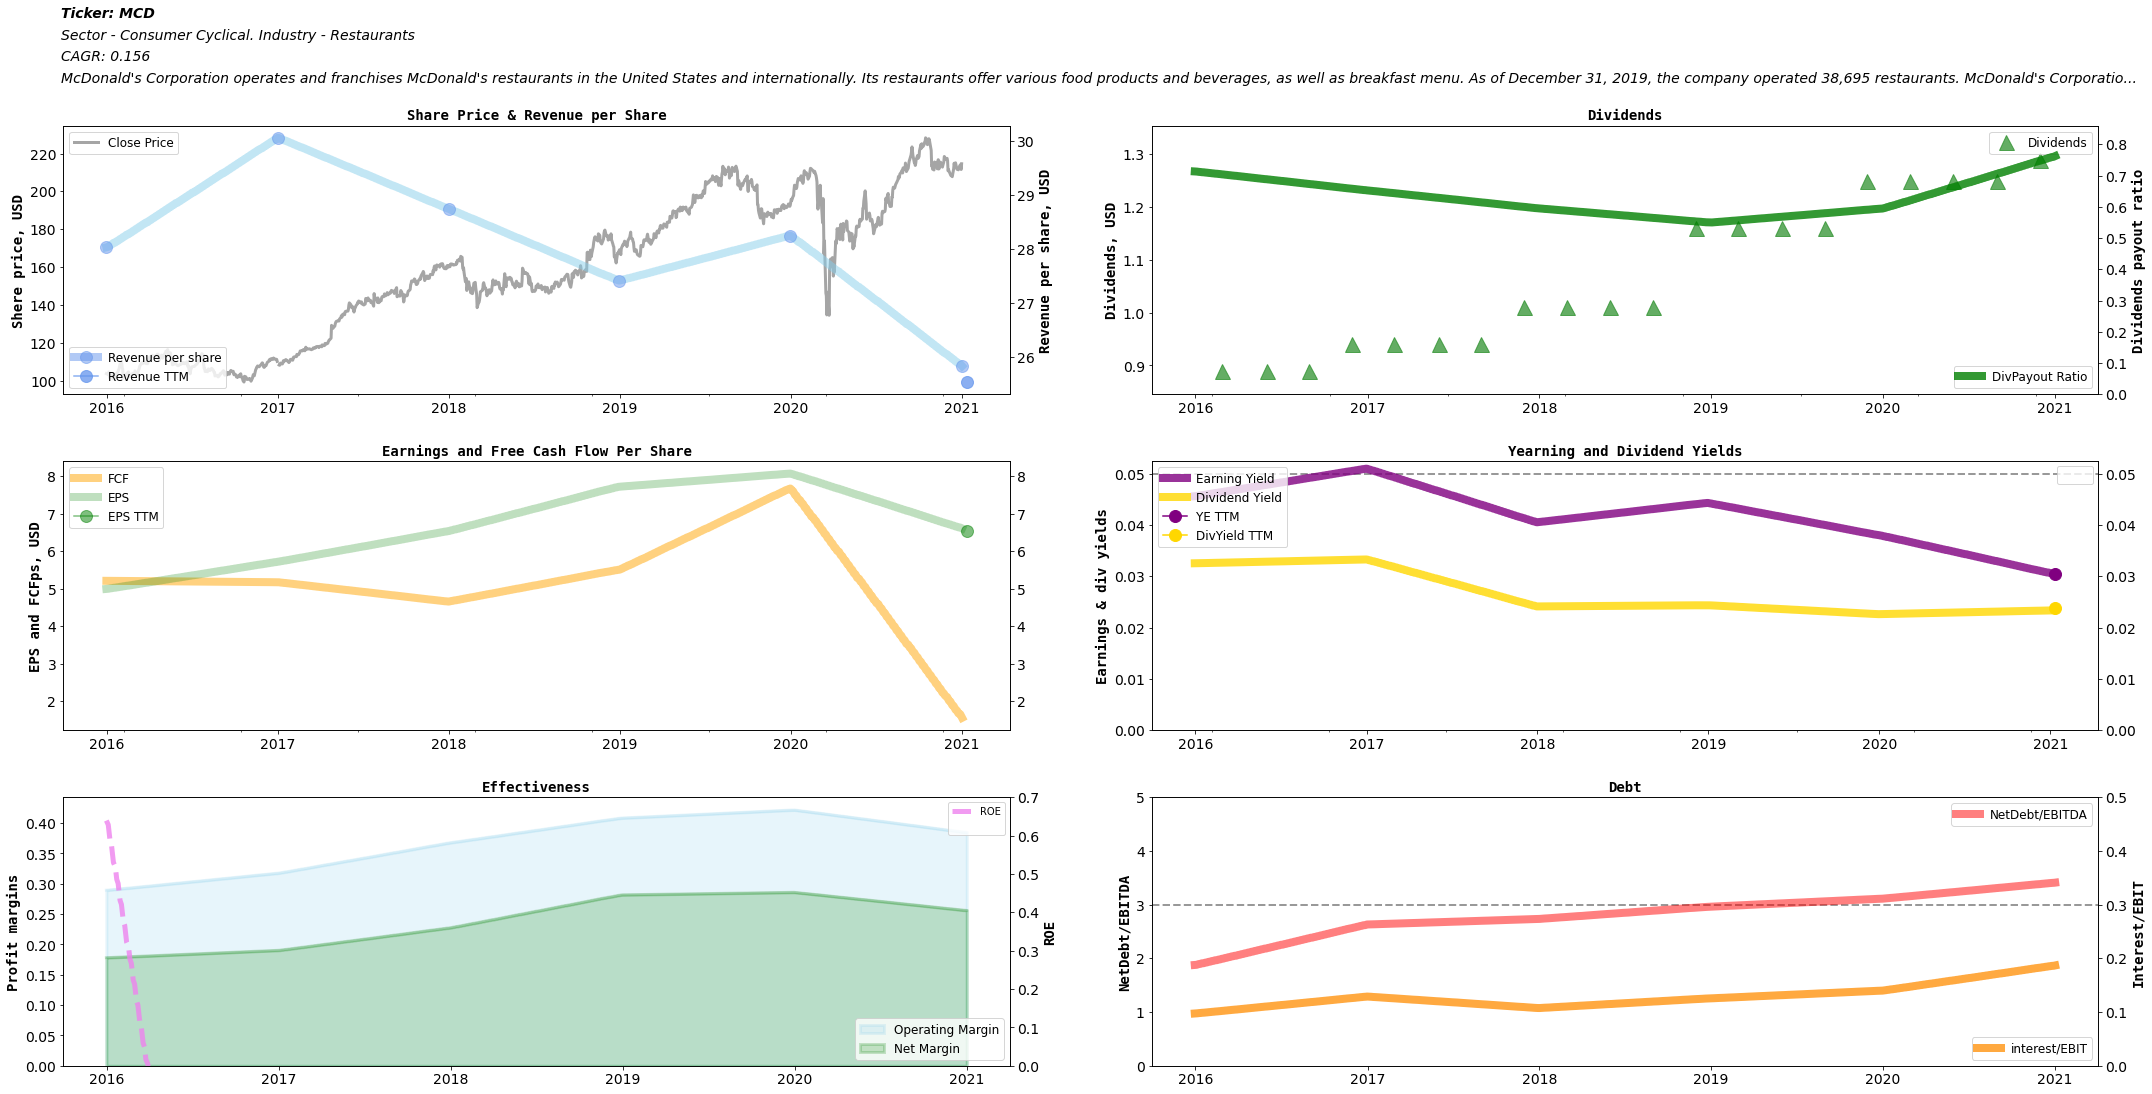

In [64]:
#Add folder name
n=1
for stockname in stocknames:
  print(stockname)
  vis_stock(stockname, print_to_folder='Coding/StockPDFs/', name_prefix=str(n))
  n=n+1